### Introduction to Topic Modelling

###### Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents.

###### Non-negative matrix factorization (NMF or NNMF), also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into (usually) two matrices W and H, with the property that all three matrices have no negative elements.

NMF stands for non-negative matrix factorization, a technique for obtaining low rank representation of matrices with non-negative or positive elements

we factorize a matrix X into two matrices W and H so that X = WH

 The matrix W  is generally called the dictionary or basis matrix, and H is known as expansion or coefficient matrix. The underlying idea is that a given data matrix A can be expressed in terms of summation of k basis vectors (columns of W) multiplied by the corresponding coefficients (columns of H)

###### Used for dimensionality reduction and clustering.

### We can use it in cojuction with TF-IDF to model topics across documents

<img src="NMF.PNG">

### Text Preprocessing

### Loading the Documents

In this notebook we will look at the steps involved in preprocessing a corpus of unstructed text documents using scikit-learn, which we will use later for topic modelling.

As our sample corpus of text, we will use a corpus of news articles collected in 2016. These articles have been stored in a single file and formatted so that one article appears on each line. We will load these articles into a list, and also create a short snippet of text for each document.

In [2]:
import os.path
raw_documents = []
snippets = []
with open( os.path.join("data", "articles.txt") ,"r", encoding="utf8") as fin:
    for line in fin.readlines():
        text = line.strip()
        raw_documents.append( text )
        # keep a short snippet of up to 100 characters as a title for each article
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


When preprocessing text, a common approach is to remove non-informative stopwords. The choice of stopwords can have a considerable impact later on. We will use a custom stopword list:

In [5]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In the bag-of-words model, each document is represented by a vector in a m-dimensional coordinate space, where m is number of unique terms across all documents. This set of terms is called the corpus vocabulary.

Since each document can be represented as a term vector, we can stack these vectors to create a full document-term matrix. We can easily create this matrix from a list of document strings using CountVectorizer from Scikit-learn. The parameters passed to CountVectorizer control the pre-processing steps that it performs.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# use a custom stopwords list, set the minimum term-document frequency to 20

vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 4551 X 10285 document-term matrix


This process also builds a vocabulary for the corpus:

In [7]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 10285 distinct terms


We can save this document-term matrix, terms, and snippets for later use using Joblib to persist the data.

In [9]:
import joblib
joblib.dump((A,terms,snippets), "articles-raw.pkl")

['articles-raw.pkl']

### Applying Term Weighting with TF-IDF

We can improve the usefulness of the document-term matrix by giving more weight to the more "important" terms. The most common normalisation is term frequency–inverse document frequency (TF-IDF). In Scikit-learn, we can generate at TF-IDF weighted document-term matrix by using TfidfVectorizer in place of CountVectorizer.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 4551 X 10285 TF-IDF-normalized document-term matrix


In [11]:
# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 10285 distinct terms


A simple characterisation that we might do would be to look at the terms with the highest TF-IDF scores across all documents in the document-term matrix. We can define such a function as follows:

In [12]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

We can now display a ranking of the top 20 terms, which gives us a very rough sense of the content of the document collection:

In [13]:
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. trump (190.87)
02. people (109.90)
03. eu (109.17)
04. film (91.35)
05. uk (89.10)
06. bank (78.69)
07. time (76.12)
08. brexit (67.98)
09. health (61.59)
10. government (60.24)
11. back (60.24)
12. clinton (59.95)
13. get (57.37)
14. world (56.85)
15. campaign (56.35)
16. women (55.82)
17. way (54.95)
18. before (54.60)
19. vote (54.33)
20. work (54.04)


Again we will save this document-term matrix, terms, and snippets for topic modelling later using Joblib.

In [14]:
joblib.dump((A,terms,snippets), "articles-tfidf.pkl") 

['articles-tfidf.pkl']

### NMF Topic Models

Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. One approach for topic modelling is to apply matrix factorisation methods, such as Non-negative Matrix Factorisation (NMF). In this notebook we look at how to apply NMF using the scikit-learn library in Python

### Applying NMF

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using Joblib:

In [16]:
import joblib
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 4551 X 10285 document-term matrix


The key input parameter to NMF is the number of topics to generate k. For the moment, we will pre-specify a guessed value, for demonstration purposes.

In [17]:
k = 10

Another choice for NMF revolves around initialisation. Most commonly, NMF involves using random initialisation to populate the values in the factors W and H. Depending on the random seed that you use, you may get different results on the same dataset. Instead, using SVD-based initialisation provides more reliable results.

In [18]:
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 

# apply the model and extract the two factor matrices
# Nonnegative Double Singular Value Decomposition (NNDSVD) [Boutsidis2007] is a new method designed to enhance the 
#initialization stage of the nonnegative matrix factorization. The basic algorithm contains no randomization and is based on 
#two SVD processes, one approximating the data matrix, the other approximating positive sections of the resulting partial SVD 
#factors utilizing an algebraic property of unit rank matrices.

W = model.fit_transform( A )
H = model.components_

### Examining the Output

NMF produces to factor matrices as its output: W and H.

The W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.

In [19]:
W.shape

(4551, 10)

For instance, for the first document, we see that it is strongly associated with one topic. However, each document can be potentially associated with multiple topics to different degrees.

In [20]:
# round to 2 decimal places for display purposes
W[0,:].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.  , 0.  , 0.  , 0.01])

The H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [21]:
H.shape

(10, 10285)

For instance, for the term "brexit", we see that it is strongly associated with a single topic. Again, in some cases each term can be associated with multiple topics.

In [22]:
term_index = terms.index('brexit')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.25, 0.  ])

### Topic Descriptors

The top ranked terms from the H factor for each topic can give us an insight into the content of that topic. This is often called the topic descriptor. Let's define a function that extracts the descriptor for a specified topic:

In [23]:
import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

We can now get a descriptor for each topic using the top ranked terms (e.g. top 10):

In [24]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: eu, uk, brexit, britain, european, leave, europe, vote, referendum, trade
Topic 02: trump, clinton, donald, republican, campaign, president, hillary, cruz, sanders, presidential
Topic 03: film, films, movie, star, director, hollywood, actor, story, drama, cinema
Topic 04: league, season, leicester, goal, premier, united, city, liverpool, game, ball
Topic 05: bank, banks, banking, financial, rbs, customers, shares, deutsche, barclays, lloyds
Topic 06: health, nhs, care, patients, mental, doctors, hospital, people, services, junior
Topic 07: album, music, band, song, pop, songs, rock, love, sound, bowie
Topic 08: facebook, internet, online, twitter, users, google, people, media, company, amazon
Topic 09: labour, party, corbyn, cameron, referendum, vote, voters, campaign, johnson, minister
Topic 10: women, abortion, woman, men, cancer, female, ireland, girls, rights, northern


The rankings above do not show the strength of association for the different terms. We can represent the distribution of the weights for the top terms in a topic using a matplotlib horizontal bar chart.

In [25]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

Define a function to create a bar chart for the specified topic, based on the H factor from the current NMF model:

In [26]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

So for instance, for the 7th topic we can generate a plot with the top 15 terms using:

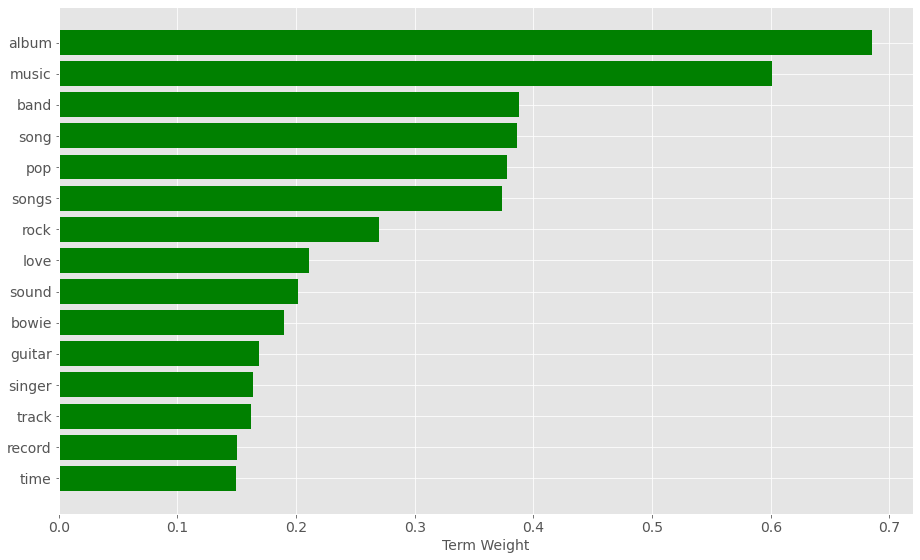

In [27]:
plot_top_term_weights( terms, H, 6, 15 )

### Most Relevant Documents

We can also look at the snippets for the top-ranked documents for each topic. We'll define a function to produce this ranking also.

In [28]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

For instance, for the first topic listed above, the top 10 documents are:

In [29]:
topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Brexit X-men: how the prime minister’s key negotiators are coping When Boris Johnson was working for
02. Archbishop accuses Farage of racism and 'accentuating fear for political gain' – EU referendum live 
03. Brexit could shift Europe's political centre of gravity, says Fitch A vote for Brexit in next month’
04. EU leaders line up to insist UK will pay a high price for Brexit stance Britain and the EU appear mo
05. Would Brexit make UK businesses less competitive? In this week’s EU referendum Q&A our panel discuss
06. David Cameron: being in the EU gives Britain key counter-terrorism information David Cameron has sai
07. Slovakian foreign minister: I will support any measure to stop Brexit The new Slovakian EU presidenc
08. Brexit weekly briefing: we're going to be kept in the dark Welcome to the weekly Brexit briefing, a 
09. What would Brexit mean for housing, regeneration and central government? Housing and regeneration: T
10. Cameron names referendum date as Gove declares for 

Similarly, for the second topic:

In [30]:
topic_snippets = get_top_snippets( snippets, W, 1, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Donald Trump: money raised by Hillary Clinton is 'blood money' – as it happened Hillary Clinton deli
02. Second US presidential debate – as it happened Here’s how searches for “Hillary Clinton” and “Donald
03. Trump campaign reportedly vetting Christie, Gingrich as potential running mates – as it happened Don
04. Donald Trump hits delegate count needed for Republican nomination – as it happened On the one hand, 
05. Trump: 'Had I been president, Capt Khan would be alive today' – as it happened Speaking with ABC New
06. Clinton seizes on Trump tweets for day of campaigning in Florida – as it happened Donald Trump was a
07. Melania Trump defends husband's 'boy talk' in CNN interview – as it happened Speaking to CNN’s Ander
08. Hillary Clinton: 'I'm sick of the Sanders campaign's lies' – as it happened One of the most importan
09. Donald Trump at the White House: Obama reports 'excellent conversation' – as it happened Are you adj
10. Donald Trump: Hillary Clinton has 'no right to be r

### Exporting the Results

If we want to keep this topic model for later user, we can save it using joblib:

In [32]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k) 

['articles-model-nmf-k10.pkl']

### Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics k.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using Joblib:

In [34]:
import joblib
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 4551 X 10285 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of k.

We need to start by pre-specifying an initial range of "sensible" values:

In [35]:
kmin, kmax = 4, 15

Apply NMF for each of these values:

In [37]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


### Build a Word Embedding

To select the number of topics, here we will use a topic coherence measure called TC-W2V. This measure relies on the use of a word embedding model constructed from our corpus. So in this step we will use the Gensim implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

We read the documents from the input file again:

In [39]:
import os.path
raw_documents = []
with open( os.path.join("data", "articles.txt") ,"r", encoding="utf8") as fin:
    for line in fin.readlines():
        raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


Read the custom stopword list:

In [40]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [41]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using Gensim:

In [42]:
import gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [43]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12192 terms


Save for later use, so that we do not need to rebuild it:

In [44]:
w2v_model.save("w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our topic coherence approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [45]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [46]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

Now process each of the models for different values of k:

In [47]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


K=04: Coherence=0.3583
K=05: Coherence=0.3962
K=06: Coherence=0.4380
K=07: Coherence=0.4583
K=08: Coherence=0.4648
K=09: Coherence=0.4582
K=10: Coherence=0.4568
K=11: Coherence=0.4571
K=12: Coherence=0.4560
K=13: Coherence=0.4552
K=14: Coherence=0.4542
K=15: Coherence=0.4535


We can now use matplotlib to generate a line plot of these coherence scores, to help us select an appropriate value.

In [48]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

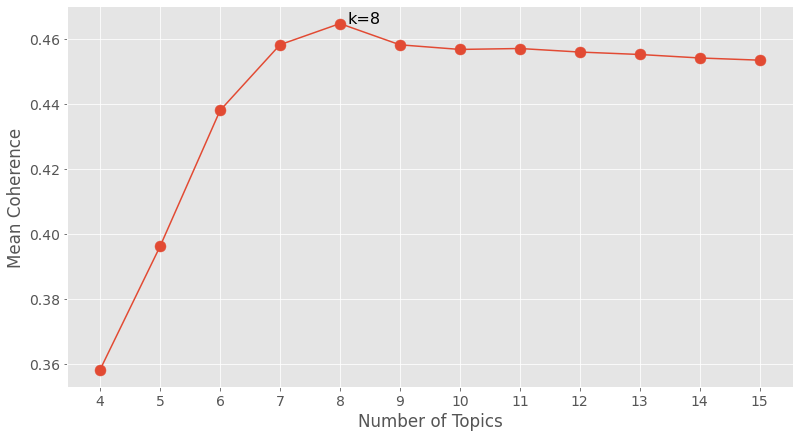

In [49]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [2]:
### Examine the Final Model

#The plot above suggests that the most appropriate value for the number of topics is k=8.

k = best_k

NameError: name 'best_k' is not defined

In [ ]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

Display the topic descriptors for this model:

In [ ]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )